# **QA System with BeerQA Dataset**
In this notebook we are going to explore the [beerqa](https://beerqa.github.io/) dataset, an open-domain question answering dataset that features questions requiring information from one or more Wikipedia documents to answer. In addition to the exploration, we are also goinig to build some QA models.
Authors:
* Rustam ALIYEV
* Vlada PRIKHODCHENKO
* Fabio CABECCIA
* Filippo SARTORI

In [1]:
import json
import random
import numpy as np
import pandas as pd
import re
import copy
import nltk
import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from nltk.corpus import stopwords
from tabulate import tabulate
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.cluster import DBSCAN
from pandas.core.common import flatten
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

In [ ]:
# Set random seed
seed = 42
random.seed(seed)

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


# Preliminary Analysis
# *Data Loading*

If you're using Kaggle platform please make sure this flag is True

In [2]:
KAGGLE = False

In [4]:
# Import data
if not KAGGLE:
    with open('/content/gdrive/MyDrive/beerqa/beerqa_train_v1.0.json') as f:
        json_train = json.load(f)
    with open('/content/gdrive/MyDrive/beerqa/beerqa_dev_v1.0.json') as f:
        json_dev = json.load(f)
    with open('/content/gdrive/MyDrive/beerqa/beerqa_test_questions_v1.0.json') as f:
        json_test = json.load(f)
else:
    with open('/kaggle/input/nlp-assignment/beerqa_train_v1.0.json') as f:
        json_train = json.load(f)
    with open('/kaggle/input/nlp-assignment/beerqa_dev_v1.0.json') as f:
        json_dev = json.load(f)
    with open('/kaggle/input/nlp-assignment/beerqa_test_questions_v1.0.json') as f:
        json_test = json.load(f)

# Data Exploration

We need to see what we have as data

In [5]:
# Check data structure for each set
print('Train set documents struct: ', json_train.keys())
print('Dev set documents struct: ', json_dev.keys())
print('Test set documents struct: ', json_test.keys(), '\n')
# Keep only the 'data' field
train_data = json_train['data']
dev_data = json_dev['data']
test_data = json_test['data']
# Print structure of the new sets
print('Train set documents struct: ', train_data[0].keys())
print('Dev set documents struct: ', dev_data[0].keys())
print('Test set documents struct: ', test_data[0].keys(), '\n')
# Clean Memory. json_train is still used later in the model section
del json_dev, json_test
# Print first document of each set
print('First document of Train Set:\n', json.dumps(train_data[0], indent=4), '\n\n')
print('First document of Dev Set:\n', json.dumps(dev_data[0], indent=4), '\n\n')
print('First document of Test Set:\n', json.dumps(test_data[0], indent=4), '\n\n')

Train set documents struct:  dict_keys(['version', 'split', 'data'])
Dev set documents struct:  dict_keys(['version', 'split', 'data'])
Test set documents struct:  dict_keys(['version', 'split', 'data']) 

Train set documents struct:  dict_keys(['id', 'src', 'answers', 'question', 'context'])
Dev set documents struct:  dict_keys(['id', 'src', 'answers', 'question', 'context'])
Test set documents struct:  dict_keys(['id', 'question']) 

First document of Train Set:
 {
    "id": "8af07575b8444ae748634478f96b00d4e7dbd170",
    "src": "squad",
    "answers": [
        "1793"
    ],
    "question": "When did Wordsworth initially attack Burke?",
    "context": [
        [
            "Edmund Burke",
            "In the 19th century, Burke was praised by both liberals and conservatives. Burke's friend Philip Francis wrote that Burke \"was a man who truly & prophetically foresaw all the consequences which would rise from the adoption of the French principles\", but because Burke wrote with so 

Now we have a better understanding of what each field contains:
* *id* - unique id of the document.
* *src* - source of the document. Basically, beerqa is a composite of squad and hotpotqa datasets, which are the only two possible values.
* *answers* - the correct answers to the question. Although it is a list, there are no documents with more than one answer.
* *question* - is the text of the question.
* *context* - a list containing the paragraphs retrieved from Wikipedia needed to answer the question.


Let's check how many words in average we have in the context.

In [ ]:
# Statistics
# n of docs in each set
n_train_docs = len(train_data)
n_dev_docs = len(dev_data)
n_test_docs = len(test_data)
#---------- CONTEXT
# Average length of the context vocabulary of each set
avg_train_context_vocabulary = np.mean([len(set(word for element in doc['context'] for word in element[1].split())) for doc in train_data])
avg_dev_context_vocabulary = np.mean([len(set(word for element in doc['context'] for word in element[1].split())) for doc in dev_data])
# Average number of words in the context of each set
avg_train_context_words = np.mean([np.mean([len(context[1].split()) for context in doc['context']]) for doc in train_data])
avg_dev_context_words = np.mean([np.mean([len(context[1].split()) for context in doc['context']]) for doc in dev_data])
#---------- QUESTION
# Average length of the question vocabulary of each set
avg_train_question_vocabulary = np.mean([len(set(word for word in doc['question'].split())) for doc in train_data])
avg_dev_question_vocabulary = np.mean([len(set(word for word in doc['question'].split())) for doc in dev_data])
avg_test_question_vocabulary = np.mean([len(set(word for word in doc['question'].split())) for doc in test_data])
# Average number of words in the question of each set
avg_train_question_words = np.mean([len(doc['question'].split()) for doc in train_data])
avg_dev_question_words = np.mean([len(doc['question'].split()) for doc in dev_data])
avg_test_question_words = np.mean([len(doc['question'].split()) for doc in test_data])
#---------- HOPS
# Number of documents gathered by number of hops required to answer the question.
n_hops_train = [sum(len(doc['context']) == 1 for doc in train_data)]+[sum(len(doc['context']) == 2 for doc in train_data)] + [sum(len(doc['context']) >= 3 for doc in train_data)]
n_hops_dev = [sum(len(doc['context']) == 1 for doc in dev_data)]+[sum(len(doc['context']) == 2 for doc in dev_data)] + [sum(len(doc['context']) >= 3 for doc in dev_data)]
# Headers for the table
headers = ['', 'Train', 'Dev', 'Test']
# Print with tabulate
print(tabulate([['Number of documents ', n_train_docs, n_dev_docs, n_test_docs],
                ['Avg context size (in words)', f"{avg_train_context_words:.3f}", f"{avg_dev_context_words:.3f}", '\\'],
               ['Avg context vocabulary size (in words)', f"{avg_train_context_vocabulary:.3f}", f"{avg_dev_context_vocabulary:.3f}", '\\'],
                ['Avg question size (in words)', f"{avg_train_question_words:.3f}", f"{avg_dev_question_words:.3f}", f"{avg_test_question_words:.3f}"],
                ['Avg question vocabulary size (in words)', f"{avg_train_question_vocabulary:.3f}", f"{avg_dev_question_vocabulary:.3f}", f"{avg_test_question_vocabulary:.3f}"],
               ['1-hops QAs', n_hops_train[0], n_hops_dev[0],'\\'],
               ['2-hops QAs', n_hops_train[1], n_hops_dev[1], '\\'],
               ['3-hops or more QAs', n_hops_train[2], n_hops_dev[2], '\\']],
               headers=headers, tablefmt="grid"))

+-----------------------------------------+------------+-----------+--------+
|                                         |      Train |       Dev | Test   |
+=========================================+============+===========+========+
| Number of documents                     | 134043     | 14121     | 14932  |
+-----------------------------------------+------------+-----------+--------+
| Avg context size (in words)             |     92.694 |   100.389 | \      |
+-----------------------------------------+------------+-----------+--------+
| Avg context vocabulary size (in words)  |    102.218 |    99.144 | \      |
+-----------------------------------------+------------+-----------+--------+
| Avg question size (in words)            |     14.336 |    12.542 | 12.635 |
+-----------------------------------------+------------+-----------+--------+
| Avg question vocabulary size (in words) |     13.44  |    11.961 | 12.016 |
+-----------------------------------------+------------+--------

The only fields of interests for our purpose are answers, question, and context. Thus we are going to cut everything else.

In [7]:
train = [{'answers': [ans for ans in doc['answers']], 'question': doc['question'],
          'context': [(context) for context in doc['context']]} for doc in train_data]
dev = [{'answers': [ans for ans in doc['answers']], 'question': doc['question'],
          'context': [(context) for context in doc['context']]} for doc in dev_data]
# Test only contains question
test = [{'question': doc['question']} for doc in test_data]
# Print new keys
print('Train set documents new keys: ', train[0].keys())
print('Dev set documents new keys: ', dev[0].keys())
print('Test set documents new keys: ', test[0].keys())

merged_train_dev = train + dev

# Free memory
del train_data, dev_data, test_data

Train set documents new keys:  dict_keys(['answers', 'question', 'context'])
Dev set documents new keys:  dict_keys(['answers', 'question', 'context'])
Test set documents new keys:  dict_keys(['question'])


## *Answers Exploration*

During our project work we realized that in the dataset answers are stored in array but we haven't seen any sample that contains more than 1 answer. We need to be sure about this.

In [ ]:
listtt = []
for t in merged_train_dev:
  if len(t["answers"]) > 1:
    listtt.append(t["answers"])

print("Amount of samples with more than 1 answer: ", len(listtt))

Amount of samples with more than 1 answer:  0


Then we decided to see how many answers consist of pure digit (years for example)

In [ ]:
# Checking the percentage of numbers only answers
count = 0
for t in merged_train_dev:
    for a in t["answers"]:
        if a.isdigit():
            count += 1

print("The number of pure number answers: ", count)
print("The number of the rest: ", len(train) - count)
print("The percentage of pure number answers: ", round(count / len(train) * 100, 2), "%")
print()

fig = go.Figure(
    data=[go.Bar(x=["Digit answers", "The rest"], y=[count, len(train) - count])],
    layout_title_text="Comparison"
)
fig.show()

The number of pure number answers:  11925
The number of the rest:  122118
The percentage of pure number answers:  8.9 %



Also we want to check how many answers contain mathematical symbols like +, -, * or /

In [ ]:
# Checking the percentage of answers containing mathematical symbols
pattern = re.compile(r'[-+*/]')
count = 0
for t in merged_train_dev:
    for a in t["answers"]:
        if re.search(pattern, a):
              count += 1

print("The number of answers containin mathematical symbols", count)
print("The number of the rest", len(train) - count)
print("The percentage of answers containin mathematical symbols", round(count / len(train) * 100, 2), "%")
print()

fig = go.Figure(
    data=[go.Bar(x=["Answers containing mathematical symbols", "The rest"], y=[count, len(train) - count])],
    layout_title_text="Comparison"
)
fig.show()

The number of answers containin mathematical symbols 4902
The number of the rest 129141
The percentage of answers containin mathematical symbols 3.66 %



And we decided to check the amount of "yes" or "no" answers.

In [ ]:
# Checking the percentage of yes/no answers
typical_answers = ["yes", "no"]
count = 0
for t in merged_train_dev:
  for a in typical_answers:
    if a.lower() in t["answers"]:
      count += 1

print("The number of simple answers", count)
print("The number of the rest", len(train) - count)
print("The percentage of simple answers", round(count / len(train) * 100, 2), "%")
print()

fig = go.Figure(
    data=[go.Bar(x=["Simple answers", "The rest"], y=[count, len(train) - count])],
    layout_title_text="Comparison"
)
fig.show()

The number of simple answers 5347
The number of the rest 128696
The percentage of simple answers 3.99 %



# **Vectorization**
The goal of this section is to build a TF-IDF model to identify the sentence that contains the answer to a given question. For starters we are going to build a vectorizer for each field of the train set, and then explore the vectorization obtained.

In [ ]:
# Build vectorizers
# context_vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')
context_vectorizer = TfidfVectorizer (
    stop_words = 'english',
    max_df = 1.0,
    min_df = 10
)
question_vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')
answer_vectorizer = TfidfVectorizer(max_df=0.3, min_df=5, stop_words='english')

#-------CONTEXT VECTORIZATION
# As first try vectorize the context => we need a unified context for all docs
context_vect = [(' '.join([' '.join(context) for context in doc['context']])) for doc in train]
# Just some checks
# print('Unified context of document 5000: \n', clean_context_vect[5000]+'\n')
# print('Original list of contexts of document 5000: \n',train[5000]['context'],'\n')
# Fit the doc to the vectorizer
context_vectorizer.fit(context_vect)
# Check again vocabulary
vocab_context = context_vectorizer.get_feature_names_out()
print(f"Length of contexts vocabulary: {len(vocab_context)}\n")
# Print 25 randomly chosen terms
print('25 randomly chosen terms from contexts:\n', sorted(random.sample(vocab_context.tolist(),25)),'\n')

#-------QUESTION VECTORIZATION
# Fit the doc to the vectorizer
question_vect = [doc['question'] for doc in train]
question_vectorizer.fit(question_vect)
# Check again vocabulary
vocab_question = question_vectorizer.get_feature_names_out()
print(f"Length of questions vocabulary: {len(vocab_question)}\n")
# Print 25 randomly chosen terms
print('25 randomly chosen terms from questions:\n', sorted(random.sample(vocab_question.tolist(),25)),'\n')


Length of contexts vocabulary: 48461

25 randomly chosen terms from contexts:
 ['1437', '62nd', '795', 'belgrade', 'code', 'comedienne', 'democratized', 'doo', 'downstairs', 'elaborating', 'franklin', 'fraudulent', 'illusionist', 'manes', 'marias', 'moneypenny', 'perching', 'rack', 'remind', 'sassou', 'sergeant', 'surge', 'usd', 'vanity', 'waterfowl'] 

Length of questions vocabulary: 18375

25 randomly chosen terms from questions:
 ['aristotle', 'ashcroft', 'blamed', 'bridges', 'britton', 'carthage', 'celtic', 'chico', 'continue', 'fairchild', 'gareth', 'gregg', 'hacker', 'instructor', 'labs', 'laura', 'mixed', 'mpeg', 'number', 'ode', 'peace', 'penguins', 'shapes', 'video', 'witherspoon'] 



In [ ]:
# Now effectively transform the context into vectorized form
vector_contexts = context_vectorizer.transform(context_vect)
vector_questions = question_vectorizer.transform([doc['question'] for doc in train])
# Print first 10 elements of the first context
print('Vectorized representation of the first word of first document\'s context:\n', vector_contexts[0][0])
# Then print 5 most used terms in the first context
print('\nTop 10 most used terms:\n', sorted([(vocab_context[j], vector_contexts[0, j]) for j in vector_contexts[0].nonzero()[1]], key=lambda x: -x[1])[:10])
# Print first question in vectorized form
print('\nVectorized representation of first document\'s question:\n', vector_questions[0])
# Then print most used terms in the first question
print('\nMost used terms:\n', sorted([(vocab_question[j], vector_questions[0, j]) for j in vector_questions[0].nonzero()[1]], key=lambda x: -x[1]))

Vectorized representation of the first word of first document's context:
   (0, 47833)	0.09413434637302566
  (0, 47823)	0.03624313146955895
  (0, 47819)	0.030902076627965208
  (0, 47730)	0.0242917605058111
  (0, 47715)	0.10395576653096215
  (0, 47714)	0.030484232437534294
  (0, 47650)	0.04886905584104634
  (0, 47465)	0.10699838383544882
  (0, 47422)	0.07034887410175401
  (0, 47189)	0.05179118971437162
  (0, 46911)	0.05279522219074008
  (0, 46154)	0.04816076864435092
  (0, 44769)	0.042047848054333946
  (0, 44146)	0.02298186562154748
  (0, 43938)	0.016395905438458515
  (0, 43538)	0.03243693247605507
  (0, 43255)	0.029923598407820388
  (0, 42742)	0.05161061837882814
  (0, 42549)	0.041075194194683834
  (0, 42224)	0.030430840708580983
  (0, 42011)	0.03979415895516385
  (0, 41593)	0.0390199836656537
  (0, 41260)	0.07483542395531176
  (0, 41230)	0.03419131857062649
  (0, 41144)	0.03248632233477978
  :	:
  (0, 8257)	0.01988106743867888
  (0, 7973)	0.8337313103473539
  (0, 7171)	0.0435905318104

# Exploration of the Vectorization
Here we use the vectorized version of the fields to measure similarity between randomly chosen documents.

In [ ]:
# SIMILARITY
#------ CONTEXT
# Check similarity between some randomly chosen documents' context
for i in range(0, 3):
    doc_1 = random.randint(0, vector_contexts.shape[0]-1)
    doc_2 = random.randint(0, vector_contexts.shape[0]-1)
    print('Similarity between contexts of document {} and {}: {:.5f}'.format(doc_1, doc_2, vector_contexts[doc_1].multiply(vector_contexts[doc_2]).sum()))
#------ QUESTIONS
# Check similarity between some randomly chosen documents' questions
print('\n')
for i in range(0, 3):
    doc_1 = random.randint(0, vector_questions.shape[0]-1)
    doc_2 = random.randint(0, vector_questions.shape[0]-1)
    print('Similarity between questions of document {} and {}: {:.5f}'.format(doc_1, doc_2, vector_questions[doc_1].multiply(vector_questions[doc_2]).sum()))
print('\n\n')
# VOCABULARY SIZE
# We expect it to be similar to the one computed in the initial analysis
# Average vocabulary size of the contexts
nonzero_count = vector_contexts.count_nonzero()
doc_count = vector_contexts.get_shape()[0]
print(f"Average contexts vocabulary size: {nonzero_count/doc_count:.3f}")
#------ QUESTIONS
# Average vocabulary size of the questions
nonzero_count = vector_questions.count_nonzero()
doc_count = vector_questions.get_shape()[0]
print(f"Average questions vocabulary size: {nonzero_count/doc_count:.3f}")

Similarity between contexts of document 26476 and 99647: 0.00460
Similarity between contexts of document 72869 and 118858: 0.00000
Similarity between contexts of document 95638 and 42638: 0.00311


Similarity between questions of document 97040 and 93132: 0.00000
Similarity between questions of document 54921 and 69986: 0.00000
Similarity between questions of document 18717 and 44862: 0.00000



Average contexts vocabulary size: 65.097
Average questions vocabulary size: 6.999


# TF-IDF Model
As said before, we use this TF-IDF model to look for similarity between the sentences inside the context and the actual question. The higher the similarity, the higher the score for a specific sentence. The idea is to then compute the accuracy in terms of correct words inside the prediction, i.e. how many words of the 'answers' are inside 'tfidf_prediction'.

In [ ]:
def tfidf_predictions_(dataset):
    """
    Identify the answer sentence as one whose TF-IDF representation has minimal distance to that of the question.

    args:
        dataset (list) : a copy of the beerqa (train) dataset
    returns:
        float: accuracy of the predictions. A prediction is correct if the corresponding answer is contained in tfidf_prediction.
    """
    # Deep copy the dataset
    tmp = copy.deepcopy(dataset)
    # Change context to a single string for each dcument
    if type(tmp[0]['context']) == list:
        tmp = [{'answers': [ans for ans in doc['answers']], 'question': doc['question'],
          'context': ' '.join([' '.join(context) for context in doc['context']])} for doc in tmp]
    # Initialize vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        tokenizer = nltk.word_tokenize,
        stop_words = stopwords.words('english'),
        ngram_range = (1,2),
        max_df = 1.0,
        min_df = 10
    )

    # Extract contexts and questions from each doc
    contexts = [doc['context'] for doc in tmp]
    questions = [doc['question'] for doc in tmp]
    # Get the vectorized version of contexts and questions
    tfidf_contexts = tfidf_vectorizer.fit_transform(contexts)
    tfidf_questions = tfidf_vectorizer.transform(questions)
    # Initialize predictions and distances
    predictions = []
    distances = []

    for i, doc in tqdm(enumerate(tmp), total=len(tmp), desc="Processing dataset"):
        # Vectorized version of current doc
        question_vector = tfidf_questions[i]
        context_vectors = tfidf_contexts[i]
        # Use the cosine similarity to find the similarity score between question and context
        similarities = cosine_similarity(question_vector, context_vectors)
        # Find index with highest similarity
        max_similarity_index = np.argmax(similarities)
        # Get sentence with highest similarity
        predicted_sentence = doc['context'].split('.')[max_similarity_index]
        # Compute the distance value between question and context
        distance_value = np.max(similarities)
        # Add the two new fields
        doc['tfidf_prediction'] = predicted_sentence
        doc['distance_value'] = distance_value
        predictions.append(predicted_sentence)
        distances.append(distance_value)

    total_words = 0
    correct_words = 0
    # Compute accuracy
    for doc in tmp:
        answer_words = set(nltk.word_tokenize(doc['answers'][0]))
        prediction_words = set(nltk.word_tokenize(doc['tfidf_prediction']))
        total_words += len(answer_words)
        # Count correct words as intersection between prediction and answer
        correct_words += len(answer_words.intersection(prediction_words))

    accuracy = correct_words / total_words if total_words > 0 else 0
    print("TF-IDF Accuracy:", f"{accuracy:.5f}")

    return tmp

In [ ]:
# Make predictions on the first 8000 documents
%time tf_idf_predictions = tfidf_predictions_(train[:8000])

Processing dataset: 100%|██████████| 8000/8000 [00:07<00:00, 1031.59it/s]


TF-IDF Accuracy: 0.43657
CPU times: user 31 s, sys: 87.7 ms, total: 31 s
Wall time: 31 s


In [ ]:
# Check the prediction of the a random document
doc = tf_idf_predictions[random.randint(0, len(tf_idf_predictions)-1)]
tmp = {field: doc[field] for field in ['answers', 'question', 'tfidf_prediction', 'distance_value']}
print(json.dumps(tmp, indent=4))

{
    "answers": [
        "workers"
    ],
    "question": "What group from the munitions plant in Woolwich formed the Arsenal club?",
    "tfidf_prediction": "Arsenal F",
    "distance_value": 0.3458339269706324
}


# Keyword Based Search


In [ ]:
# Some queries on the already vectorized training set
query = 'italy'
query_1 = 'computer'

query_context = context_vectorizer.transform([query])[0]
query_question = question_vectorizer.transform([query])[0]
query_context_1 = context_vectorizer.transform([query_1])[0]
query_question_1 = question_vectorizer.transform([query_1])[0]

index_context = np.argmax([query_context.multiply(vector_contexts[i]).sum() for i in range(vector_contexts.shape[0])])
index_question = np.argmax([query_question.multiply(vector_questions[i]).sum() for i in range(vector_questions.shape[0])])
print('Context query \'italy\' results:', context_vect[index_context])
print('Question query \'italy\' results:', question_vect[index_question])

index_context = np.argmax([query_context_1.multiply(vector_contexts[i]).sum() for i in range(vector_contexts.shape[0])])
index_question = np.argmax([query_question_1.multiply(vector_questions[i]).sum() for i in range(vector_questions.shape[0])])
print('Context query \'italy\' results:', context_vect[index_context])
print('Question query \'italy\' results:', question_vect[index_question])

Context query 'italy' results: Italy national football team The Italy national football team ( ) has officially represented Italy in international football since their first match in 1910. The squad is under the global jurisdiction of FIFA and is governed in Europe by UEFA—the latter of which was co-founded by the Italian team's supervising body, the Italian Football Federation (FIGC). Italy's home matches are played at various stadiums throughout Italy, and their primary training ground, Centro Tecnico Federale di Coverciano, is located at the FIGC technical headquarters in Coverciano, Florence. Italy national football team Italy is one of the most successful national teams in the history of the World Cup, having won four titles (1934, 1938, 1982, 2006) and appearing in two other finals (1970, 1994), reaching a third place (1990) and a fourth place (1978). In 1938, they became the first team to defend their World Cup title, and due to the outbreak of World War II, retained the title f

# **Clustering**

It would be too naive to use simple approach such as K-means for such a big data. Instead, we will be using topic modelling via LDA

In [8]:
# Remove punctuation using regex expressions
clean_train = [{'answers': [re.sub(r'[^a-zA-Z0-9\s]', '', ans) for ans in doc['answers']], 'question': re.sub(r'[^a-zA-Z0-9\s]', '', doc['question']),
          'context':   [[re.sub(r'[^a-zA-Z0-9\s]', '', element) for element in context] for context in doc['context']]} for doc in train]

For LDA clustering the number of words is crucial. The only field that has enough words is the context. Since we have it only in train data, we will divide the train data itself into the training and test parts

In [9]:
clean_data_clustering = [(' '.join([' '.join(context) for context in doc['context']])) for doc in clean_train]

ratio = 0.8
split_index = int(len(clean_data_clustering) * ratio)
clean_train_clustering = clean_data_clustering[:split_index]
clean_test_clustering = clean_data_clustering[split_index:]


In [10]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', min_df=100, max_df=0.5)
vector_documents_train = vectorizer.fit_transform(clean_train_clustering)
vocab = vectorizer.get_feature_names_out()
print(f"Length of vocabulary: {len(vocab)}\n")

Length of vocabulary: 9364



However, for LDA the exact number of topics should be specified. To find the optimal one, we will use Elbow method to find the optimal number of topics. Note, that we will be using quite low number of iterations just to save the time.

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# --- Elbow method ---

vector_documents_test = vectorizer.transform(clean_test_clustering)

# In that array we will store the perplexity value to measure the performance
performance = []
for num_of_topics in range(2, 21, 1):
    print("Number of topics - ", num_of_topics)
    lda = LatentDirichletAllocation(n_components=num_of_topics, verbose=1, learning_method='online', max_iter=10)
    lda.fit(vector_documents_train)
    performance.append(lda.perplexity(vector_documents_test))

Number of topics -  2
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Number of topics -  3
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Number of topics -  4
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Number of topics -  5
iteration: 1 of max_iter: 10
iteration:

Now let's plot the graph and find the optimal number of topics!

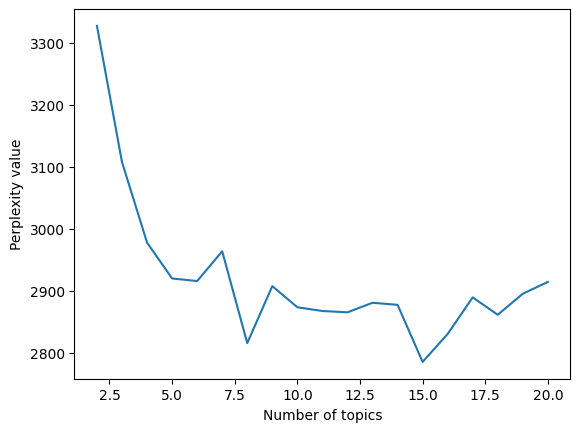

In [ ]:
plt.figure()
plt.plot(range(2, 21),performance)
plt.ylabel('Perplexity value')
plt.xlabel('Number of topics')
plt.show()

Remember that lower perplexity does not always mean the best performance. As seen from the graph above, the optimal values for the number of topics are in a range from 5 to 10. Let's explore the topics with the case of 5. We will print the most important words corresponding to the topics. But this time we will increase the number of iterations for LDA.

In [ ]:
lda = LatentDirichletAllocation(n_components=5, verbose=1, learning_method='online', max_iter=30)
lda.fit(vector_documents_train)

for i in range(len(lda.components_)):
    sorted_terms = lda.components_[i].argsort()[::-1]
    concatenated_terms = '[' + ', '.join(vocab[i] for i in sorted_terms[:10]) + ']'
    print (f'Topic {i + 1}:\t', concatenated_terms)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30
Topic 1:	 [football, season, league, team, game, born, played, professional, games, national]
Topic 2:	 [war,

Seems like some topics coincide. Let's try now with 7 topics and 50 iterations:

In [43]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=7, verbose=1, learning_method='online', max_iter=50)
lda.fit(vector_documents_train)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

LatentDirichletAllocation(learning_method='online', max_iter=50, n_components=7,
                          verbose=1)

In [47]:
most_important_words = []
for i in range(len(lda.components_)):
    sorted_terms = lda.components_[i].argsort()[::-1]
    concatenated_terms = '[' + ', '.join(vocab[i] for i in sorted_terms[:10]) + ']'
    most_important_words.append(vocab[sorted_terms[0]])
    print (f'Topic {i + 1}:\t', concatenated_terms)

Topic 1:	 [used, use, time, magazine, century, language, called, form, developed, published]
Topic 2:	 [film, american, series, born, television, directed, known, best, films, actor]
Topic 3:	 [war, university, states, united, state, school, government, british, president, air]
Topic 4:	 [album, band, music, released, song, rock, american, singer, single, studio]
Topic 5:	 [city, new, south, north, states, located, area, united, county, york]
Topic 6:	 [football, season, league, team, born, game, played, national, professional, games]
Topic 7:	 [family, species, king, church, known, court, john, english, genus, death]


Now this looks way better! Let's try to find the number of the corresponding most important topics in the dataset of contexts!

In [48]:
most_important_topics = [0 for i in range(7)]
for doc in clean_test_clustering:
  topic_vector = lda.transform(vectorizer.transform([doc])[0])[0]
  max_i = 0
  max_vector_value = topic_vector[0]
  for i in range(1, 7):
    if topic_vector[i] > max_vector_value:
      max_vector_value = topic_vector[i]
      max_i = i
  most_important_topics[max_i] += 1
print(most_important_topics)

[5129, 5589, 4506, 3001, 4270, 2399, 1915]


In [49]:
print(most_important_words)

fig = go.Figure(
    data=[go.Bar(x=most_important_words, y=most_important_topics)],
    layout_title_text="Comparison"
)
fig.show()

['used', 'film', 'war', 'album', 'city', 'football', 'family']


# **Word Embedding**

In [ ]:
!pip install --upgrade gensim

In [ ]:
# Prepare the data

train_ = []
# Iterate through each document in the input data
# We will be working with questions this time
for doc in json_train['data']:
    # Add the question to the texts list
    train_.append(doc['question'])

# To see some examples
print(train_[0])
print(train_[1])
print(train_[2])

# Just in case the question contains more than 1 sentence
sentences_train = [re.split('[?!.]\s', doc) for doc in train_]
print("After splitting into sentences by special signs")
print(sentences_train[:3])

#Use the command from pandas library to flatten the structure into one big array of sentences
sentences_train = list(flatten(sentences_train))
#sentences_train[:20]

#Cleaning of data by eliminating non-letter characters and tokenize the sentences based on whitespaces
tokenized_sentences_train = [re.sub('\W', ' ', sentence).lower().split() for sentence in sentences_train]
#Remove sentences that are only 1 word long
tokenized_sentences_train = [sentence for sentence in tokenized_sentences_train if len(sentence) > 1]

for sentence in tokenized_sentences_train[:3]:
    print(sentence)

#Now we can provide data to the algorithm, since the format is right

model_train = Word2Vec(tokenized_sentences_train, vector_size=30, min_count=5, window=10)

#Check vocabulary size
len(model_train.wv)

When did Wordsworth initially attack Burke?
The clash between Henry IV and the pope was part of what greater conflict?
What historical event brought about the fall of the Robespierres?
After splitting into sentences by special signs
[['When did Wordsworth initially attack Burke?'], ['The clash between Henry IV and the pope was part of what greater conflict?'], ['What historical event brought about the fall of the Robespierres?']]
['when', 'did', 'wordsworth', 'initially', 'attack', 'burke']
['the', 'clash', 'between', 'henry', 'iv', 'and', 'the', 'pope', 'was', 'part', 'of', 'what', 'greater', 'conflict']
['what', 'historical', 'event', 'brought', 'about', 'the', 'fall', 'of', 'the', 'robespierres']


18937

# Inspecting embeddings and finding similar words

In [ ]:
term = 'country'

model_train.wv[term]
model_train.wv.most_similar(term)

[('city', 0.7048143744468689),
 ('province', 0.6717204451560974),
 ('state', 0.6647626161575317),
 ('county', 0.6576027274131775),
 ('england', 0.6500034332275391),
 ('region', 0.620689868927002),
 ('district', 0.5966678261756897),
 ('continent', 0.5958325266838074),
 ('town', 0.5951489806175232),
 ('ravenna', 0.5920096635818481)]

## *Using t-SNE to visualize the embedding vectors*


We'll proceed to generate visualizations of certain word vectors in a three-dimensional space utilizing t-SNE. Since we have a large vocabulary, we will consider a random subset composed of 1000 terms


In [ ]:
sampled_train = random.sample(list(model_train.wv.key_to_index), 1000)
print(sampled_train)

['humphrey', 'immigrant', 'coloratura', 'chechen', 'fortification', 'fabrice', 'buttons', 'socially', 'trophy', 'mama', 'round', 'anand', 'swear', 'hoosiers', 'athlete', 'newport', 'nutrition', 'throw', 'criticize', 'waht', 'florian', 'thicke', 'ladies', 'keenan', 'chapman', 'saturn', 'pennines', 'kelli', 'heterosexual', 'comeback', 'jewels', 'champ', 'hicks', 'vii', 'hamadan', 'vendéen', 'require', 'stores', 'chapter', 'roosevelt', 'sammy', 'moist', 'lincoln', 'possibility', 'unlv', 'byrd', 'strawberry', 'oval', 'merseyside', 'voice', 'abandoned', 'ekaterina', 'kangxi', 'guzmán', '1931', 'nichols', 'criss', 'archipelago', 'sonam', 'comedy', 'riverside', 'jeux', 'loose', 'arrondissement', 'reform', 'truly', 'interim', 'whats', 'assets', 'schmeling', '1761', 'american', 'compton', 'atlético', '5', 'caribbean', 'underneath', 'arden', 'tube', 'clothing', 'aeneas', 'pizarro', 'estonian', 'ninth', 'mauritius', 'circuit', 'northumbrian', 'lynch', 'portray', 'bretagne', 'mcnabb', 'recruited',

In [ ]:
#Get the word vectors for the terms
word_vectors_train = model_train.wv[sampled_train]
word_vectors_train

array([[ 0.1520331 ,  0.00102992,  0.11374427, ...,  0.28551948,
         0.04140193, -0.3193955 ],
       [-0.15010808,  0.11318211,  0.28637376, ..., -0.09733778,
        -0.10468565, -0.4959964 ],
       [ 0.05871778,  0.04802268, -0.06460011, ...,  0.0312202 ,
         0.02758624, -0.10121597],
       ...,
       [-0.36891118, -0.22779833, -0.1776077 , ...,  0.5049667 ,
         0.39738595, -0.35772583],
       [-0.08491669, -0.04774669,  0.12081616, ...,  0.02337912,
         0.00192433, -0.17360765],
       [ 0.18103692, -0.0752294 ,  0.06733204, ...,  0.14760853,
         0.00337984, -0.18921122]], dtype=float32)

In [ ]:
#Provide the vectors to SNE
tsne = TSNE(n_components=3, n_iter=2500)
tsne_embedding = tsne.fit_transform(word_vectors_train)

#Transform data into 3 columns
x, y, z = np.transpose(tsne_embedding)

Build the 3D plot, we also label some points to see the words they correspond to

In [ ]:
!pip install plotly

In [ ]:
fig = px.scatter_3d(x=x[:400],y=y[:400],z=z[:400],text=sampled_train[:400])
fig.update_traces(marker=dict(size=5,line=dict(width=3)),textfont_size=15)
fig.show()

Now let's use some numbers to extend the set of words and see if they cluster

In [ ]:
numbers = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15']

word_vectors = model_train.wv[numbers+sampled_train]

tsne = TSNE(n_components=3)
tsne_embedding = tsne.fit_transform(word_vectors)

x, y, z = np.transpose(tsne_embedding)

r = (-400,400)
fig = px.scatter_3d(x=x, y=y, z=z, range_x=r, range_y=r, range_z=r, text=numbers + [None] * 1000)
fig.update_traces(marker=dict(size=5,line=dict(width=3)),textfont_size=15)
fig.show()

Same with the animals

In [ ]:
animals = ['lion','tiger','elephant','panda','leopard','cheetah','gorilla','monkey','chimpanzee']

word_vectors_train = model_train.wv[animals+sampled_train]

tsne = TSNE(n_components=3)
tsne_embedding = tsne.fit_transform(word_vectors_train)

x, y, z = np.transpose(tsne_embedding)

r = (-400,400)
fig = px.scatter_3d(x=x, y=y, z=z, range_x=r, range_y=r, range_z=r, text=animals + [None] * 1000)
fig.update_traces(marker=dict(size=5,line=dict(width=3)),textfont_size=15)
fig.show()

# **Training Models**
- BERT
- FLAN T5

## FLAN T5
We are going to fine tune a pretrained T5 model with beerqa.

In [ ]:
!pip install datasets

In [ ]:
import torch
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from transformers import T5Tokenizer
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### *Data Pre-Processing*
For starters we need to convert our dataset into the correct format:

**input**
question: question_text  context: context

**target**
*answer_text*

In [ ]:
# Import the model's tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-base')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Function to build input sequence. Note that in addition to the format question: 'question' context: 'context' we also need an eof token
def add_eos_to_examples(example):
    # Since there may be multiple hops, unify the contexts of each example in order to get a single string
    # example['context'] = ' '.join([' '.join(context) for context in example['context']])
    # Build the input
    example['input_text'] = 'question: %s  context: %s </s>' % (example['question'], example['context'])
    # Build the target
    example['target_text'] = '%s </s>' % example['answers'][0]
    return example

# Function to tokenize the examples made
def convert_to_features(example_batch):
    # Encode the inputs and the outputs using the T5 tokenizer. Note that we pad the inputs to a maximum length of 512 and the
    # outputs to a maximum length of 16 (zero-padding)
    input_encodings = tokenizer.batch_encode_plus(example_batch['input_text'], pad_to_max_length=True, max_length=512)
    target_encodings = tokenizer.batch_encode_plus(example_batch['target_text'], pad_to_max_length=True, max_length=16)
    # Set the newly obtained encoding
    encodings = {
        'input_ids': input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'target_ids': target_encodings['input_ids'],
        'target_attention_mask': target_encodings['attention_mask']
    }

    return encodings

In [ ]:
# Function to split into train and validation
def train_val_split(dataset, val=0.2, seed=42):
    """
    Divide the list into train and validation sets

    :param data: original dataset.
    :param val: percentage of data used for building the validation set. Default is 0.2 (20%).
    :param seed: Reproducibility seed. Default is 42.
    :return: tuple (train, validation).
    """
    random.seed(seed)
    val_size = int(len(dataset) * val)
    val_set = random.sample(dataset, val_size)
    # Now, get all the indices of validation set and use it to find remaining data, which will be the train set
    val_indices = [doc['id'] for doc in val_set]
    train_set = [doc for doc in dataset if doc['id'] not in val_indices]
    # Now remove all fields but answers, question, and context
    train_set = [{'answers': [ans for ans in doc['answers']], 'question': doc['question'], 'context': [context for context in doc['context']]} for doc in train_set]
    val_set = [{'answers': [ans for ans in doc['answers']], 'question': doc['question'], 'context': [context for context in doc['context']]} for doc in val_set]

    return train_set, val_set

In [ ]:
# Divide train in train and validation split.
val = 0.2
# For simplicity we are going to use not the total training data
train_dataset, valid_dataset = train_val_split(json_train['data'][:7000], val)

# Build the datasets for training. For simplicity we first convert each of the two datasets into pandas dataframes,
#and then build the Dataset object using Dataset
train_dataset = Dataset.from_pandas(pd.DataFrame(train_dataset))
valid_dataset = Dataset.from_pandas(pd.DataFrame(valid_dataset))
# Build the dataset for evaluation. Here too we use dataframes for simplicity and a smaller version of the dev dataset
eval_dataset = Dataset.from_pandas(pd.DataFrame(dev[:7000]))

# Map add_eos_to_examples function to the dataset example wise. Basically add the needed tokens to each document.
train_dataset = train_dataset.map(add_eos_to_examples)
# Map convert_to_features batch wise. Convert to the format required by the model
train_dataset = train_dataset.map(convert_to_features, batched=True)
# Same reasoning for the validation set and the eval_dataset
valid_dataset = valid_dataset.map(add_eos_to_examples, load_from_cache_file=False)
valid_dataset = valid_dataset.map(convert_to_features, batched=True, load_from_cache_file=False)
eval_dataset = eval_dataset.map(add_eos_to_examples, load_from_cache_file=False)
eval_dataset = eval_dataset.map(convert_to_features, batched=True, load_from_cache_file=False)

# Set the tensor type and the columns which the dataset should return
columns = ['input_ids', 'target_ids', 'attention_mask', 'target_attention_mask']
train_dataset.set_format(type='torch', columns=columns)
valid_dataset.set_format(type='torch', columns=columns)
eval_dataset.set_format(type='torch', columns=columns)

Map:   0%|          | 0/5600 [00:00<?, ? examples/s]

Map:   0%|          | 0/5600 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5.py:309: UserWarning:

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

In [ ]:
# Check the length of the new sets
print('Train set size: ', len(train_dataset), '\nValidation set size: ', len(valid_dataset), '\nEvaluation set size: ', len(eval_dataset))
# Cach the dataset, so we can load it directly for training
torch.save(train_dataset, 'train_data.pt')
torch.save(valid_dataset, 'valid_data.pt')
torch.save(eval_dataset, 'eval_data.pt')

Train set size:  5600 
Validation set size:  1400 
Evaluation set size:  7000


### *Fine Tuning*

In [ ]:
from transformers import DataCollatorForLanguageModeling
from transformers import TrainingArguments, Trainer
from typing import Dict, List, Optional

# Define the collator for our dataset
# We need a customised collator to map the target_ids tl the 'labels' field of the elements of the batch.
# prepares labels from target_ids, returns examples with keys as expected by the forward method
def collate_batch(batch: List, tokenizer:tokenizer) -> Dict[str, torch.Tensor]:
        """
        Take a list of samples from a Dataset and collate them into a batch.
        Returns:
            A dictionary of tensors
        """
        input_ids = torch.stack([example['input_ids'] for example in batch])
        # lm_labels are now simply called labels in T5ForConditionalGenerator
        lm_labels = torch.stack([example['target_ids'] for example in batch])
        # Here we put to -100 the value of the tokens with 0-value, which are present due to 0 padding.
        # This way they are not considered when computing the loss.
        lm_labels[lm_labels[:, :] == 0] = -100
        attention_mask = torch.stack([example['attention_mask'] for example in batch])
        decoder_attention_mask = torch.stack([example['target_attention_mask'] for example in batch])


        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': lm_labels,
            'decoder_attention_mask': decoder_attention_mask
        }

2024-05-26 12:25:28.579459: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-26 12:25:28.579559: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-26 12:25:28.732027: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Prepare the arguments for the trainer
training_args = TrainingArguments(
    "t5_trainer",
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,  # Gradient accumulation to use batch sized larger the available VRAM
    learning_rate=1e-5,
    num_train_epochs= 10,
    lr_scheduler_type="linear",
    remove_unused_columns=False,
    log_level='info',
    do_train=True
)


In [ ]:
# Define the model
from transformers import T5ForConditionalGeneration, T5Tokenizer, EvalPrediction
model = T5ForConditionalGeneration.from_pretrained(
    't5-base'
)

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# Build the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=lambda data: collate_batch(data, tokenizer)
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

***** Running training *****
  Num examples = 5,600
  Num Epochs = 10
  Instantaneous batch size per device = 4
  Training with DataParallel so batch size has been adjusted to: 8
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 8
  Total optimization steps = 870
  Number of trainable parameters = 222,903,552
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
0,No log,0.393507
2,No log,0.321149
4,No log,0.304805
6,0.404100,0.299803
8,0.404100,0.297932
9,0.404100,0.297872


***** Running Evaluation *****
  Num examples = 1400
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1400
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1400
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1400
  Batch size = 16
***** Running Evaluation *****
  Num examples = 1400
  Batch size = 16
Saving model checkpoint to t5_trainer/checkpoint-500
Configuration saved in t5_trainer/checkpoint-500/config.json
Configuration saved in t5_trainer/checkpoint-500/generation_config.json
Model weights saved in t5_trainer/checkpoint-500/model.safetensors
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 1400
  Batch size = 16
***** Running Evaluation *****
  Num examples =

TrainOutput(global_step=870, training_loss=0.3652862373439745, metrics={'train_runtime': 5299.2966, 'train_samples_per_second': 10.567, 'train_steps_per_second': 0.164, 'total_flos': 3.39067753463808e+16, 'train_loss': 0.3652862373439745, 'epoch': 9.94})

In [ ]:
# Save the fine tuned model, plus the tokenizer
from datetime import datetime

checkpoint_path = f"t5_fine_tuning_{datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}"
tokenizer.save_pretrained(checkpoint_path)
model.save_pretrained(checkpoint_path)
print(f"Checkpoint saved at: \'{checkpoint_path}\'")

tokenizer config file saved in t5_fine_tuning_2024_05_26_13_54_05/tokenizer_config.json
Special tokens file saved in t5_fine_tuning_2024_05_26_13_54_05/special_tokens_map.json
added tokens file saved in t5_fine_tuning_2024_05_26_13_54_05/added_tokens.json
Configuration saved in t5_fine_tuning_2024_05_26_13_54_05/config.json
Configuration saved in t5_fine_tuning_2024_05_26_13_54_05/generation_config.json
Model weights saved in t5_fine_tuning_2024_05_26_13_54_05/model.safetensors


Checkpoint saved at: 't5_fine_tuning_2024_05_26_13_54_05'


### *Evaluation*
Now we are going to evaluate our newly fine-tuned model on the dev beerqa set. The evaluation script is taken, but slightly modified, from the T5 Fine tuning [guide](https://colab.research.google.com/github/patil-suraj/exploring-T5/blob/master/T5_on_TPU.ipynb#scrollTo=QLGiFCDqvuil), which is in turn adapted from the SQuAD evaluation script available [here](https://github.com/allenai/bi-att-flow/blob/master/squad/evaluate-v1.1.py)

In [ ]:
# Build a dataloader to feed the eval_dataset to the model
dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=32, collate_fn=lambda data: collate_batch(data, tokenizer))
# Restore the model
tokenizer = T5Tokenizer.from_pretrained(checkpoint_path)
model = T5ForConditionalGeneration.from_pretrained(checkpoint_path).to(device)
# Set the model to evaluation
model.eval()

loading file spiece.model
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading file tokenizer.json
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
loading configuration file t5_fine_tuning_2024_05_26_13_54_05/config.json
Model config T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_atten

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [ ]:
## SQuAD evaluation script. Modifed slightly for this notebook

from __future__ import print_function
from collections import Counter
import string
import re
import argparse
import json
import sys

# Safety in case the strings have different length.
def pad_strings(str1, str2):
    len1 = len(str1)
    len2 = len(str2)

    max_len = max(len1, len2)

    if len1 < max_len:
        str1 = str1.ljust(max_len)
    if len2 < max_len:
        str2 = str2.ljust(max_len)

    return str1, str2

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        if len(ground_truth)!=len(prediction):
              ground_truth, prediction = pad_strings(ground_truth, prediction)
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)


def evaluate(gold_answers, predictions):
    f1 = exact_match = total = 0

    for ground_truths, prediction in zip(gold_answers, predictions):
        total += 1
        exact_match += metric_max_over_ground_truths(
                    exact_match_score, prediction, ground_truths)
        f1 += metric_max_over_ground_truths(
          f1_score, prediction, ground_truths)

    exact_match = 100.0 * exact_match / total
    f1 = 100.0 * f1 / total

    return {'exact_match': exact_match, 'f1': f1}

In [ ]:
# Get the predictions from our model
answers = []
# For each batch made by the data loader generate an answer, then decode it using the T5 tokenizer
for batch in tqdm.tqdm(dataloader):
    outs = model.generate(input_ids=batch['input_ids'].to(device),
                        attention_mask=batch['attention_mask'].to(device),
                        max_length=16,
                        early_stopping=True)
    outs = [tokenizer.decode(ids) for ids in outs]
    answers.extend(outs)

  0%|          | 0/219 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:535: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
100%|██████████| 219/219 [06:09<00:00,  1.69s/it]


In [ ]:
# Restore the ground truth of the evaluation dataset
def add_answers(example, idx):
    example['answer'] = eval_dataset['answers'][idx]
    return example
# Add the correct answer to each element of the dataset
eval_dataset_ = eval_dataset.map(add_answers, with_indices=True)

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

In [ ]:
predictions = []
references = []
# Build golden answer and prediction dictionary which will be fed to the evaluate function
for ref, pred in zip(eval_dataset_, answers):
    # Here we had to remove the padding and the end of string tokens which are added to the output by the model
    predictions.append(pred.replace("<pad>", "").replace("</s>", ""))
    references.append(ref['answer'])

# Call the evaluate function
evaluate(references, predictions)

{'exact_match': 68.52857142857142, 'f1': 80.32793970461822}

In [ ]:
# Print some random examples of pairs ground truth, prediction
n_of_samples = 15
for i in range(n_of_samples):
    idx = random.randint(0, len(predictions)-1)
    print('Ground truth: {}, Prediction: {}\n'.format(references[idx], predictions[idx]))

Ground truth: ['The Spinners'], Prediction:  The Spinners

Ground truth: ['The Spiral'], Prediction:  New York World Building

Ground truth: ["'gifts' and biased information"], Prediction:  marketing 'gifts' and biased information

Ground truth: ['American War of Independence'], Prediction:  American War of Independence

Ground truth: ['Eddie Izzard'], Prediction:  Eddie Izzard

Ground truth: ['Egremont'], Prediction:  Egremont

Ground truth: ['Funafuti International Airport'], Prediction:  Funafuti International Airport

Ground truth: ['Gamal Abdul Nasser'], Prediction:  Gamal Abdul Nasser

Ground truth: ['Maurice Hilleman'], Prediction:  Maurice Hilleman

Ground truth: ['Latka Gravas'], Prediction:  Latka Gravas

Ground truth: ['Jeremy Renner'], Prediction:  Jeremy Lee Renner

Ground truth: ['1895'], Prediction:  1895

Ground truth: ['A bantam'], Prediction:  A bantam

Ground truth: ['Melanie Oudin'], Prediction:  Melanie Oudin

Ground truth: ['Othonna'], Prediction:  Stangeria



In [ ]:
# Clean cache
torch.cuda.empty_cache()

## BERT

In [ ]:
from transformers import BertTokenizer, BertForQuestionAnswering
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import pipeline

### *Data Pre-Processing*
Moving data to a pd DataFrame

In [ ]:
df_train = pd.DataFrame(train[:int(0.2*len(train))])
df_dev = pd.DataFrame(dev[:int(0.2*len(dev))])
df_test = pd.DataFrame(test[:int(0.2*len(test))])

In [ ]:
df_train.head()

,answers,question,context
0,[1793],When did Wordsworth initially attack Burke?,"[[Edmund Burke, In the 19th century, Burke was..."
1,[Investiture Controversy],The clash between Henry IV and the pope was pa...,"[[Middle Ages, During the early High Middle Ag..."
2,[the Thermidorian Reaction],What historical event brought about the fall o...,"[[Napoleon, Some contemporaries alleged that B..."
3,[Morales],Who came up with a policy for indigenous auton...,"[[Indigenous peoples of the Americas, Morales ..."
4,[Darren Lynn Bousman],"Greg Hoffman was working on ""Saw III,"" a 2006 ...","[[Saw III, Saw III is a 2006 horror film direc..."


We need to extract answers from lists and also combine lists in context

In [ ]:
df_train['answers'] = df_train['answers'].apply(lambda x: x[0])
df_dev['answers'] = df_dev['answers'].apply(lambda x: x[0])

In [ ]:
def combine_context(context):
    combined_text = ""
    for passage in context:
        combined_text += (". ").join(passage) + ". "
    return combined_text.strip()

In [ ]:
df_train['context'] = df_train['context'].apply(combine_context)
df_dev['context'] = df_dev['context'].apply(combine_context)

In [ ]:
df_train.head()

,answers,question,context
0,1793,When did Wordsworth initially attack Burke?,"Edmund Burke. In the 19th century, Burke was p..."
1,Investiture Controversy,The clash between Henry IV and the pope was pa...,Middle Ages. During the early High Middle Ages...
2,the Thermidorian Reaction,What historical event brought about the fall o...,Napoleon. Some contemporaries alleged that Bon...
3,Morales,Who came up with a policy for indigenous auton...,Indigenous peoples of the Americas. Morales be...
4,Darren Lynn Bousman,"Greg Hoffman was working on ""Saw III,"" a 2006 ...",Saw III. Saw III is a 2006 horror film directe...


Now data looks ready to be processed

#### Tokenizer
As BERT can process not more than 512 tokens (including CLS and SEP), we need to check if the data has more than 512 tokens in context + question.

In [ ]:
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_ac

First of all, let's see if there're more than 510 words in each context.

In [ ]:
greater_than_510_words = len([1 for i, row in df_train.iterrows() if len(row['context'].split()) + len(row['question'].split()) > 510])
dev_greater_than_510_words = len([1 for i, row in df_dev.iterrows() if len(row['context'].split()) + len(row['question'].split()) > 510])
print("Percentage of > 510 words in train data: ", round(greater_than_510_words/len(df_train) * 100, 2), "%")
print("Percentage of > 510 words in dev data: ", round(dev_greater_than_510_words/len(df_dev) * 100, 2), "%")

Percentage of > 510 words in train data:  0.17 %
Percentage of > 510 words in dev data:  0.07 %


As we can see, it's very small so we just drop it.

In [ ]:
df_train = df_train[df_train.apply(lambda row: len(row['context'].split(' ')) + len(row['question'].split(' ')) <= 510, axis=1)]
df_dev = df_dev[df_dev.apply(lambda row: len(row['context'].split(' ')) + len(row['question'].split(' ')) <= 510, axis=1)]

Now let's tokenize and see if ther're are samples with more than 512 tokens.

In [ ]:
sen_length = []

for idx, (sentence, question) in tqdm(enumerate(zip(df_train['context'], df_train['question'])), total=len(df_train)):
    token_words = tokenizer_bert.encode_plus(sentence, question)["input_ids"]
    sen_length.append(len(token_words))

100%|██████████| 26763/26763 [03:06<00:00, 143.19it/s]


In [ ]:
sen_length_dev = []

for idx, (sentence, question) in tqdm(enumerate(zip(df_dev['context'], df_dev['question'])), total=len(df_dev)):
    token_words = tokenizer_bert.encode_plus(sentence, question)["input_ids"]
    sen_length_dev.append(len(token_words))

100%|██████████| 2822/2822 [00:18<00:00, 148.88it/s]


In [ ]:
print('TRAIN: Max amount of tokens in sentence is ', max(sen_length))
print('DEV: Max amount of tokens in sentence is ', max(sen_length_dev))

TRAIN: Max amount of tokens in sentence is  977
DEV: Max amount of tokens in sentence is  655


Let's see the distribution of amount of tokens in our dataset

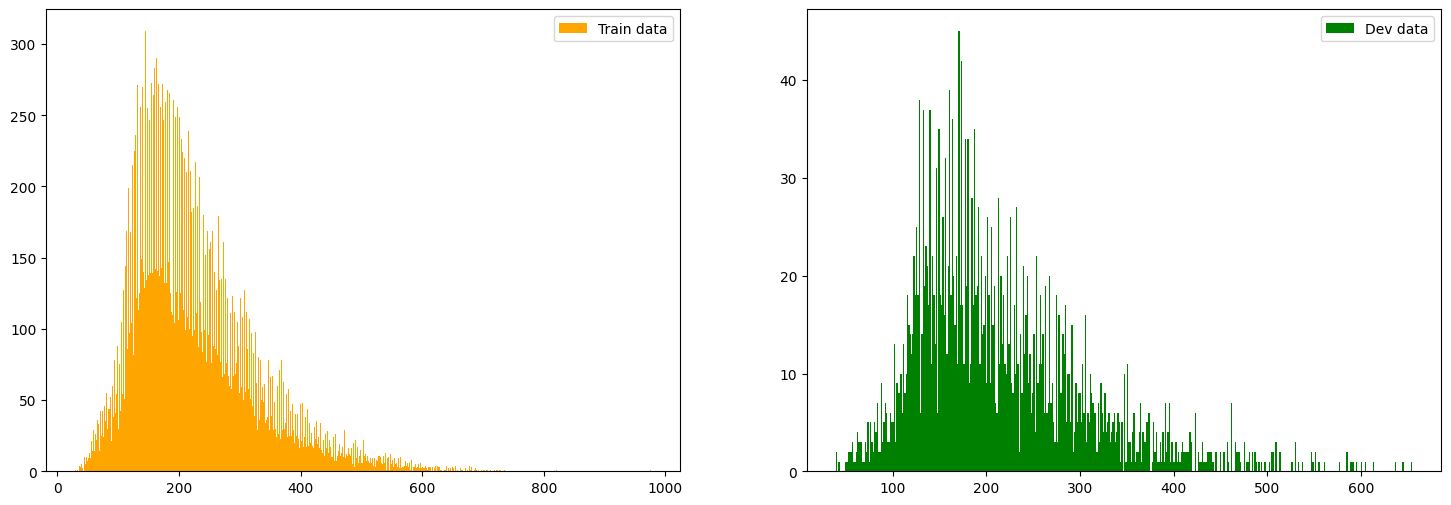

In [ ]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.hist(sen_length, color='orange', bins=len(set(sen_length)), label='Train data')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(sen_length_dev,color='green', bins=len(set(sen_length_dev)), label='Dev data')
plt.legend()

plt.show()

In [ ]:
# train data

greater_than_512 = len([num for num in sen_length if num > 512])
print("Number of data: ", len(sen_length))
print("Number of contexts > 512 tokens: ", greater_than_512)
print("Percentage of not suited data for BERT: ", round(greater_than_512/len(sen_length) * 100, 2), "%")

# dev data
dev_greater_than_512 = len([num for num in sen_length_dev if num > 512])
print("Number of data: ", len(sen_length_dev))
print("Number of contexts > 512 tokens: ", dev_greater_than_512)
print("Percentage of not suited data for BERT: ", round(dev_greater_than_512/len(sen_length_dev) * 100, 2), "%")

Number of data:  26763
Number of contexts > 512 tokens:  442
Percentage of not suited data for BERT:  1.65 %
Number of data:  2822
Number of contexts > 512 tokens:  30
Percentage of not suited data for BERT:  1.06 %


So little not suited data so we just drop it

In [ ]:
df_train['num_tokens'] = sen_length
df_train = df_train[df_train['num_tokens'] <= 510]
df_dev['num_tokens'] = sen_length_dev
df_dev = df_dev[df_dev['num_tokens'] <= 510]

#### Get test data with answers
We want to extract 5 random samples from dev data to look at the answers provided by the model and compare them to actual ones.

In [ ]:
try_data = df_dev.sample(frac=5/len(df_dev))
df_dev = df_dev.drop(try_data.index)

#### Dataset class for BERT

Let's prepare dataset and dataloader for BERT

In [ ]:
class BERTDataSet(Dataset):

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        context = item['context']
        question = item['question']
        answer = item['answers']

        bert_sens = tokenizer_bert.encode_plus(
                                question,
                                context,
                                add_special_tokens = True,
                                max_length = 510,
                                padding='max_length',
                                truncation=True,
                                return_attention_mask = True)

        ids = torch.tensor(bert_sens['input_ids'], dtype=torch.long)
        mask = torch.tensor(bert_sens['attention_mask'], dtype=torch.long)
        token_type_ids = torch.tensor(bert_sens['token_type_ids'], dtype=torch.long)

        # Convert answer text to start and end token indices
        start_token_idx = self.find_sublist(answer.split(), context.split())
        if (start_token_idx != -1):
              end_token_idx = start_token_idx + len(answer) - 1
        else:
              end_token_idx = -1
        start_idx = torch.tensor(start_token_idx, dtype=torch.long)
        end_idx = torch.tensor(end_token_idx, dtype=torch.long)

        return {
                'ids': ids,
                'mask': mask,
                'token_type_ids': token_type_ids,
                'start_idx': start_idx,
                'end_idx': end_idx
            }

    def find_sublist(self, sublist, lst):
        """Find the starting index of sublist in lst."""
        for i in range(len(lst) - len(sublist) + 1):
            if lst[i:i + len(sublist)] == sublist:
                return i
        return -1

In [ ]:
# Use this if you want to drop some data
# df_train = df_train.sample(frac=0.3, random_state=SEED)

In [ ]:
train_dataset = BERTDataSet(df_train)
valid_dataset = BERTDataSet(df_dev)

### *Fine Tuning*

In [ ]:
train_batch = 16
valid_batch = 16

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=train_batch, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size=valid_batch, shuffle = False)

In [ ]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('Total:   ', round(torch.cuda.mem_get_info(0)[1]/1024**3,1), 'GB')

Tesla T4
Memory Usage:
Allocated: 13.9 GB
Cached:    14.5 GB
Total:    14.7 GB


In [ ]:
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to('cuda:1')

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.39.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/model.safetensors
Some weights of the model check

Let's see how regular BERT answers questions

In [ ]:
qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer_bert)

for idx, example in try_data.iterrows():
    question = example['question']
    context = example['context']
    answer = example['answers']
    result = qa_pipeline(context=context, question=question)
    print("Question: ", question)
    print("Real answer: ", answer)
    print("Model answer:", result['answer'])
    print("Score:", result['score'])
    print("Start index:", result['start'])
    print("End index:", result['end'])
    print()

Question:  Which species of trees is larger Dryopteris or Gymnocladus?
Real answer:  Dryopteris
Model answer: is a small genus of leguminous
Score: 4.115424962947145e-05
Start index: 100
End index: 130

Question:  Which host of Sunday Night Safran has the hebrew first name Yehoshua?
Real answer:  John Safran
Model answer: things ethnic." It was hosted by John
Score: 0.00015449625789187849
Start index: 149
End index: 186

Question:  Both the 2010–11 UEFA Champions League knockout phase  and 011 UEFA Champions League Final were held at what London stadium?
Real answer:  Wembley
Model answer: in each of their
Score: 0.00011908326268894598
Start index: 697
End index: 713

Question:  What was the first manufactured fiber?
Real answer:  rayon
Model answer: polyester garments in the 1960s caused economic hardship in cotton-exporting
Score: 5.114061787026003e-05
Start index: 883
End index: 959

Question:  What was the title of the article Nasser wrote for his school paper?
Real answer:  Voltai

What if we train model on the data?

In [ ]:
model.train()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [this](https://ai-scholar.tech/en/articles/bert/bert-fine-tuning) article we've seen that the best learning rate with Adam is 2e-5

In [ ]:
LR=2e-5
optimizer = torch.optim.AdamW(model.parameters(), LR)

#### Training loop

In [ ]:
total_train_loss = 0
epochs = 1 # specify here amount of epochs to go through
model.to('cuda:1')

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [ ]:
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"):
        optimizer.zero_grad()

        ids = batch['ids']
        mask = batch['mask']
        token_type_ids = batch['token_type_ids']
        start_idx = batch['start_idx']
        end_idx = batch['end_idx']

        outputs = model(input_ids=ids.to('cuda:1'),
                      attention_mask=mask.to('cuda:1'),
                      token_type_ids=token_type_ids.to('cuda:1'),
                      start_positions=start_idx.to('cuda:1'),
                      end_positions=end_idx.to('cuda:1'))

        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Average Training Loss for Epoch {epoch+1}: {avg_train_loss}")
    model.save_pretrained(f'bert_qa_model_{epoch+1}_epoch')
    tokenizer_bert.save_pretrained(f'bert_qa_tokenizer_{epoch+1}_epoch')

Training Epoch 1: 100%|██████████| 1645/1645 [43:08<00:00,  1.57s/it]
Configuration saved in bert_qa_model_1_epoch/config.json


Average Training Loss for Epoch 1: 3.383063135103614


Model weights saved in bert_qa_model_1_epoch/model.safetensors


NameError: name 'tokenizer' is not defined

In [ ]:
tokenizer_bert.save_pretrained(f'bert_qa_tokenizer_{epoch+1}_epoch')

tokenizer config file saved in bert_qa_tokenizer_1_epoch/tokenizer_config.json
Special tokens file saved in bert_qa_tokenizer_1_epoch/special_tokens_map.json


('bert_qa_tokenizer_1_epoch/tokenizer_config.json',
 'bert_qa_tokenizer_1_epoch/special_tokens_map.json',
 'bert_qa_tokenizer_1_epoch/vocab.txt',
 'bert_qa_tokenizer_1_epoch/added_tokens.json')

### *Evaluation*

In [ ]:
model.to('cuda:1')

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [ ]:
model.eval()
total_val_loss = 0

with torch.no_grad():
    for batch in tqdm(valid_dataloader, desc="Validating"):
        ids = batch['ids']
        mask = batch['mask']
        token_type_ids = batch['token_type_ids']
        start_idx = batch['start_idx']
        end_idx = batch['end_idx']
        outputs = model(input_ids=ids.to('cuda:1'), attention_mask=mask.to('cuda:1'), token_type_ids=token_type_ids.to('cuda:1'),
                        start_positions=start_idx.to('cuda:1'), end_positions=end_idx.to('cuda:1'))

        loss = outputs.loss
        total_val_loss += loss.item()

avg_val_loss = total_val_loss / len(valid_dataloader)
print(f"Average Validation Loss: {avg_val_loss}")

Validating: 100%|██████████| 175/175 [01:51<00:00,  1.56it/s]

Average Validation Loss: 3.267399832861764


### *QA*

In [ ]:
model_path = f'bert_qa_model_{epochs}_epoch'
tokenizer_path = f'bert_qa_tokenizer_{epochs}_epoch'
qa_pipeline = pipeline("question-answering", model=model_path, tokenizer=tokenizer_path)

loading configuration file bert_qa_model_1_epoch/config.json
Model config BertConfig {
  "_name_or_path": "bert_qa_model_1_epoch",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.39.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading configuration file bert_qa_model_1_epoch/config.json
Model config BertConfig {
  "_name_or_path": "bert_qa_model_1_epoch",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classif

In [ ]:
for idx, example in try_data.iterrows():
    question = example['question']
    context = example['context']
    answer = example['answers']
    result = qa_pipeline(context=context, question=question)
    print("Question: ", question)
    print("Real answer: ", answer)
    print("Model answer:", result['answer'])
    print("Score:", result['score'])
    print("Start index:", result['start'])
    print("End index:", result['end'])
    print()

Question:  Which species of trees is larger Dryopteris or Gymnocladus?
Real answer:  Dryopteris
Model answer: γυμνὀς, "gymnos", naked +
Score: 0.0004162282857578248
Start index: 48
End index: 73

Question:  Which host of Sunday Night Safran has the hebrew first name Yehoshua?
Real answer:  John Safran
Model answer: J, about "religion, politics and all things ethnic." It was
Score: 0.00015899456047918648
Start index: 112
End index: 171

Question:  Both the 2010–11 UEFA Champions League knockout phase  and 011 UEFA Champions League Final were held at what London stadium?
Real answer:  Wembley
Model answer: winners received the European Champion Clubs' Cup (
Score: 5.7953457144321874e-05
Start index: 236
End index: 287

Question:  What was the first manufactured fiber?
Real answer:  rayon
Model answer: succession of new synthetic fibers were introduced by the chemicals industry in the following decades
Score: 6.36753611615859e-05
Start index: 317
End index: 418

Question:  What was the ti

# Conclusions
In the Baseline Model IRRR provided with the data the average F1 is 59.3 </br>
While T5 model has F1 equal to 80.3 but its value is normalized on the number of predictions made, which is only 7000 due to hardware and time restrictions. </br>
For BERT we couldn't reach good results because we were able to learn the model only for one epoch so at the end we got loss equal to 3.27 which is incredibly high. </br>
QA examples explicitly show us that T5 model deals well with answering but BERT no.   